
<font size="5">Fake News Detector</font>

A Naive Bayes classifier will be used to try to detect fake news.

This correspond to a Kaggle dataset, from which the data was downloaded (https://www.kaggle.com/c/fake-news/).

The score obtained in the challenge was **0.97** of accuracy!

Some EDA and data preprocessing were performed, namely: Classes balancing, Handling of Missing Data, Text cleaning, Analysis of the relationship between author and news veracity and Analysis of the relationship between text length and news veracity.


In [314]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import recall_score, precision_score

import scipy.sparse as sp

import csv


pd.set_option('mode.chained_assignment', None)


In [95]:
#Load data

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [326]:
print('Example of a fake new title:')
train_df[train_df['label'] == 1].iloc[2]['title']

Example of a fake new title:


'15 Civilians Killed In Single US Airstrike Have Been Identified'

In [325]:
print('Example of a true new title:')
train_df[train_df['label'] == 0].iloc[2]['title']

Example of a true new title:


'Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times'

## Exploratory Data Analysis

### Classes balancing

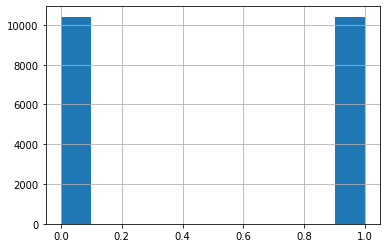

In [96]:
train_df['label'].hist()
plt.show()


The classes are well balanced, meaning that the number of fake news is similar to the number of true news

### Missing Data

In [317]:
print('Percentage Nans: ', round(train_df.isna().sum().sum()/len(train_df), 3))
train_df.isna().sum()

Percentage Nans:  0.123


id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [98]:
train_df[train_df.isna().any(axis=1)]

,id,title,author,text,label
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1
...,...,...,...,...,...
20745,20745,Thomas Frank Explores Whether Hillary Clinton ...,NaN,Thomas Frank Explores Whether Hillary Clinton ...,1
20768,20768,Osama bin Laden’s older brother rents out luxu...,NaN,Osama bin Laden’s older brother rents out luxu...,1
20771,20771,NaN,Letsbereal,DYN's Statement on Last Week's Botnet Attack h...,1
20772,20772,NaN,beersession,Kinda reminds me of when Carter gave away the ...,1


As we can see, some columns have Nans, thus they need to be replaced or removed:
- ***title***: As the number of Nans in the title column is relatively small and it is important for identifying fake news, the news with Nans in the title will be **removed**.
- ***text***: Similarly to *title* column, the *text* column with Nans will be **removed** as the text is important to detect if news are fake or not.
- ***author***: In this case, as *author* is not the most significant field in detecting fake news and there are a big number of news without it, all the news with Nans will be replaced by **unknown author**.


In [99]:
#Handle Missing data

#drop rows with Nans on title or text
train_df = train_df[~train_df[['title', 'text']].isna().any(axis=1)]

#fill Nan author field with default
train_df[['author']] = train_df[['author']].fillna('Unknown author')

print("Number of Nans: {}".format(train_df.isna().sum().sum()))

Number of Nans: 0


### Clean Strange characters and punctuation

In [101]:
train_df['text'] = train_df['text'].apply(lambda x: x.replace("\n", ""))
train_df['text'] = train_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

### Analysis of the relationship between author and news veracity

In [121]:
authors_fake = []
for ind, data in train_df.groupby('author'):
    n_pos = len(data[data['label'] == 1])/len(data)
    n_neg = len(data[data['label'] == 0])/len(data)
    
    if n_pos == 1 and len(data) > 20:
        authors_fake.append(ind)
        
print("Authors who wrote fake news, with more than 20 written news:\n", authors_fake)

Authors who wrote fake news, with more than 20 written news:
 ['-NO AUTHOR-', 'Aaron Kesel', 'Activist Post', 'Admin', 'Admin - Orissa', 'Alex Ansary', 'Amanda Froelich', 'Amy Moreno', 'Andrew Anglin', 'Arnaldo Rodgers', 'Arnold Monteverde (noreply@blogger.com)', 'Author', 'BareNakedIslam', 'Brianna Acuesta', 'C.E. Dyer', 'Colin Taylor', 'Consortiumnews.com', 'Contributing Author', 'Corbett', 'Daily Bell Staff', 'Daisy Luther', 'Daniel Greenfield', 'Dave Hodges', 'David Stockman', 'Dikran Arakelian (noreply@blogger.com)', 'Dr. Patrick Slattery', 'EdJenner', 'Eddy Lavine', 'Editor', 'Edmondo Burr', 'Geoffrey Grider', 'Gerry McBride', 'Gillian', 'Grant Stern', 'Guest', 'Heather Callaghan', 'Henry Wolff', 'Howard Portnoy', 'IWB', 'Iron Sheik', 'Jafe Arnoldski (noreply@blogger.com)', 'Jameson Parker', 'Jason Ditz', 'Jason Easley', 'Julius Hubris', 'Kaitlyn Stegall', 'King World News', 'Lance Schuttler', 'Mac Slavo', 'Madeline', 'Michael Snyder', 'Mike Rivero', 'No Author', 'Pakalert', 'Pau

### Analysis of the relationship between text length and news veracity

In [182]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split(" ")))
train_df['binning_length'] = pd.qcut(train_df['text_length'], 15)

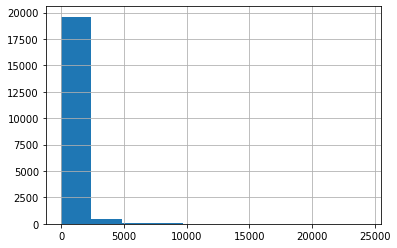

binning_length
(0.999, 102.0]       1355
(102.0, 179.0]       1361
(179.0, 245.0]       1338
(245.0, 312.0]       1347
(312.0, 375.0]       1341
(375.0, 446.0]       1346
(446.0, 535.0]       1345
(535.0, 641.4]       1342
(641.4, 765.0]       1352
(765.0, 901.0]       1342
(901.0, 1049.0]      1351
(1049.0, 1204.0]     1349
(1204.0, 1375.0]     1342
(1375.0, 1718.0]     1346
(1718.0, 24234.0]    1346
Name: label, dtype: int64

In [183]:
train_df['text_length'].hist()
plt.show()

train_df.groupby(['binning_length'])['label'].count()

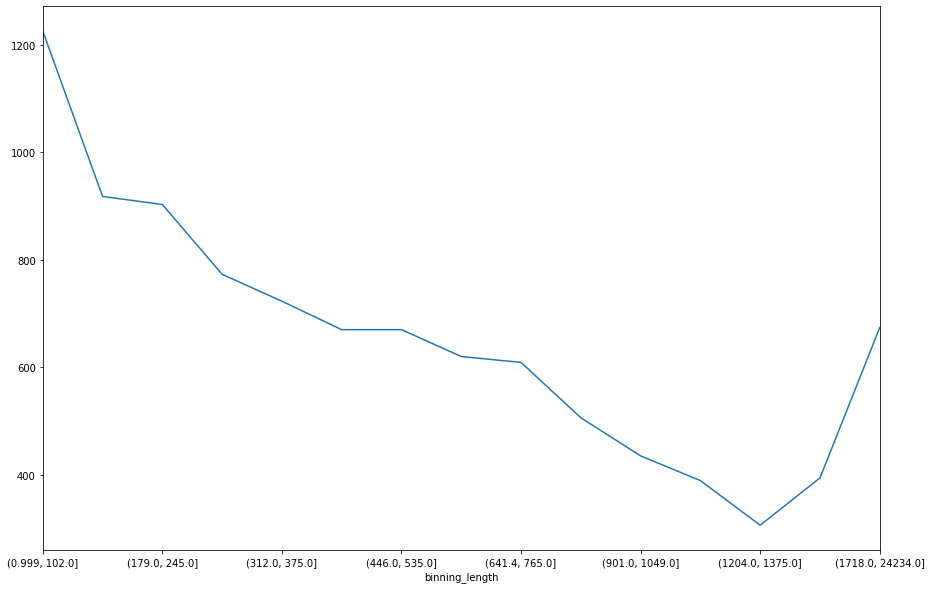

In [184]:
plt.figure(figsize=(15, 10))
train_df.groupby(['binning_length'])['label'].sum().plot()
plt.show()


By seeing the graph above, generally we would conclude that the lengthier the text the higher the probability of being legit news, however in the final end there is a unexpected increase in the number of fake news. Nevertheless, the text length should be a relevant feature to determine the veracity of news.

## Create a pipeline to preprocess data

The data will be loaded again and be processed using a data pipeline built based on the insights obtained aboved from the EDA

In [267]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [268]:
#auxiliary functions, created based on the EDA performed above

#missing data
def handle_missing_data(df):
    #drop rows with Nans on title or text
    df = df[~df[['title', 'text']].isna().any(axis=1)]

    #fill Nan author field with default
    df[['author']] = df[['author']].fillna('Unknown author')

    return df


#feature engineering
def cleaning_punctuation(df):
    df['text'] = df['text'].apply(lambda x: x.replace("\n", ""))
    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

def text_length(df):
    df.loc[:, 'text_length'] = df['text'].apply(lambda x: len(x.split(" ")))
    
    return df


In [269]:
#Preprocess data

X_train = (
    train_df
    .pipe(handle_missing_data)
    .pipe(cleaning_punctuation)
    .pipe(text_length)
)

X_test = (
    test_df
    .pipe(handle_missing_data)
    .pipe(cleaning_punctuation)
    .pipe(text_length)
)

y_train = X_train['label']
X_train.drop(['label'], axis = 1, inplace = True)

X_train.head()

,id,title,author,text,text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide We Didn’t Even See Comey’s Lett...,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,Why the Truth Might Get You Fired October 29 2...,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,154


**TF-IDF**

In [270]:
# applying TF-IDF for the text fields: title, author and text
def reconstruct_input(X_train, X_test):
    
    count_model_1 = TfidfVectorizer(decode_error='ignore', stop_words='english', max_features=1000).fit(X_train['title'])
    count_model_2 = TfidfVectorizer(decode_error='ignore', stop_words='english', max_features=1000).fit(X_train['author'])
    count_model_3 = TfidfVectorizer(decode_error='ignore', stop_words='english', max_features=1000).fit(X_train['text'])

    X_train = sp.hstack([count_model_1.transform(X_train['title']), 
                      count_model_2.transform(X_train['author']),
                      count_model_3.transform(X_train['text'])])
    
    X_test = sp.hstack([count_model_1.transform(X_test['title']), 
                      count_model_2.transform(X_test['author']),
                      count_model_3.transform(X_test['text'])])

    return X_train, X_test

In [318]:

X_train_cnt, X_test_cnt = reconstruct_input(X_train.copy(), X_test.copy())

model = MultinomialNB()
model.fit(X_train_cnt, y_train)

print("Training Accuracy:", round(model.score(X_train_cnt, y_train), 3))
print("Training Precision:", round(precision_score(y_train, model.predict(X_train_cnt)), 3))
print("Training Recall:", round(recall_score(y_train, model.predict(X_train_cnt)), 3))

results = model.predict(X_test_cnt)

Training Accuracy: 0.981
Training Precision: 0.995
Training Recall: 0.966


The training *accuracy*, *precision* and *recall* have high values (closer to 1), although it can also be a sign of overfitting.

### Extract results to csv

In [312]:
with open('results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])
    
    X_test_inds = list(X_test['id'].values)
    
    for ind, i in test_df['id'].iteritems():
        #if the news were removed due to missing author or title, then it is labeled as fake news
        if i not in X_test_inds:
            writer.writerow([i, 1])
        
        else:
            writer.writerow([i, results[X_test_inds.index(i)]])


The obtained results were quite satisfying, as seen by the results of the training metrics and also the overall score on this challenge.

Nevertheless, there are some aspects that may improve the results (in future work). The text length may possibly be relevant for the fake news detection (as seen above), thus it may be useful to incorporate this information as a new feature in the classifier. Also, the filtering of fake news based on the authors that only posted fake news could improve the results.